<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/experiment/gan_style_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# load data

In [1]:
import pandas as pd
import joblib
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_train.csv',index_col=0)
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c620_col_names.pkl')

case_col = c['case']
feed_col = c['x41']
op_col = c['density']+c['yRefluxRate']+c['yHeatDuty']+c['yControl']
wt_col = c['vent_gas_x']+c['distillate_x']+c['sidedraw_x']+c['bottoms_x']
all_col = case_col + feed_col + op_col + wt_col

print(len(case_col))
print(len(feed_col))
print(len(op_col))
print(len(wt_col))

df[all_col].head(1)

3
41
10
164


,Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Compositio

In [2]:
case_col_idx = [all_col.index(i) for i in case_col]
feed_col_idx = [all_col.index(i) for i in feed_col]
op_col_idx = [all_col.index(i) for i in op_col]
wt_col_idx = [all_col.index(i) for i in wt_col]

In [3]:
print(len(wt_col)) # 41*4 = 164
wt_col.index('Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%')

164


89

# preprocess data

In [4]:
from sklearn.utils import shuffle
from torch.utils.data import TensorDataset,DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch

df = shuffle(df)
p1 = int(len(df)*0.8)
p2 = int(len(df)*0.9)

train = torch.FloatTensor(df[all_col].values[:p1])
vaild = torch.FloatTensor(df[all_col].values[p1:p2])
test = torch.FloatTensor(df[all_col].values[p2:])


trainset = TensorDataset(train[:,case_col_idx],train[:,feed_col_idx],train[:,op_col_idx],train[:,wt_col_idx])
train_iter = DataLoader(trainset,batch_size=64)

vaildset = TensorDataset(vaild[:,case_col_idx],vaild[:,feed_col_idx],vaild[:,op_col_idx],vaild[:,wt_col_idx])
vaild_iter = DataLoader(vaildset,batch_size=64)

testset = TensorDataset(test[:,case_col_idx],test[:,feed_col_idx],test[:,op_col_idx],test[:,wt_col_idx])
test_iter = DataLoader(testset,batch_size=64)

# def model,loss,optimizer

In [5]:
import torch
from torch import nn
import torch.nn.functional as F

def mlp(sizes, activation, output_activation=nn.Identity):
  layers = []
  for j in range(len(sizes)-1):
    act = activation if j < len(sizes)-2 else output_activation
    layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
  return nn.Sequential(*layers)

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.op_model = mlp([len(case_col)+len(feed_col),256,256,256,len(op_col)],nn.ReLU)
    self.sp_model = mlp([len(case_col)+len(feed_col)+len(op_col),256,256,256,len(wt_col)],nn.ReLU,nn.Sigmoid)

  def forward(self,case,feed):
    op = self.op_model(torch.cat((case,feed),dim=-1)).clone()
    sp = self.sp_model(torch.cat((case,feed,op),dim=-1)).clone()
    for idx in range(41):
      sp[:,[idx,idx+41,idx+41*2,idx+41*3]] = self.normalize(sp[:,[idx,idx+41,idx+41*2,idx+41*3]])
    s1,s2,s3,s4 = sp[:,:41],sp[:,41:41*2],sp[:,41*2:41*3],sp[:,41*3:41*4]
    w1,w2,w3,w4 = self.sp2wt(feed,s1),self.sp2wt(feed,s2),self.sp2wt(feed,s3),self.sp2wt(feed,s4)
    wt = torch.cat((w1,w2,w3,w4),dim=-1)
    return wt,op

  @staticmethod
  def normalize(x):
    return x / x.sum(dim=1).reshape(-1,1)
  
  @staticmethod
  def sp2wt(x,s):
    a = 100*x*s
    b = torch.diag(x@s.T).reshape(-1,1)
    b = torch.clip(b,1e-8,float('inf'))
    return a/b

# model optimizer loss_fn
model = Model()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.SmoothL1Loss()

# forward test
for case,feed,op,wt in train_iter:
  wt_hat,op_hat = model(case,feed)
  print(wt_hat.shape)
  print(op_hat.shape)
  break

torch.Size([64, 164])
torch.Size([64, 10])


# train model

In [6]:
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from copy import deepcopy

# train step
def train_step(model):
  model.train()
  total_loss = 0
  for t,(case,feed,op,wt) in enumerate(train_iter):
    wt_hat,op_hat = model(case,feed)
    wt_loss = loss_fn(wt_hat,wt)
    op_loss = loss_fn(op_hat,op)
    Sidedraw_Benzene_loss = loss_fn(wt_hat[:,89],wt[:,89])
    loss = wt_loss + op_loss + 5*Sidedraw_Benzene_loss
    
    # update model
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    total_loss += loss.item()
  return total_loss/(t+1)

# valid step
def valid_step(model):
  model.eval()
  total_loss = 0
  for t,(case,feed,op,wt) in enumerate(vaild_iter):
    wt_hat,op_hat = model(case,feed)
    wt_loss = loss_fn(wt_hat,wt)
    op_loss = loss_fn(op_hat,op)
    Sidedraw_Benzene_loss = loss_fn(wt_hat[:,89],wt[:,89])
    loss = wt_loss + op_loss + Sidedraw_Benzene_loss
    total_loss += loss.item()
  return total_loss/(t+1)

def train(model,max_epochs): 
  history = {
      'train_loss':[],
      'valid_loss':[]
      }
  current_loss = np.inf
  best_model = None
  for i in tqdm(range(max_epochs)):
      history['train_loss'].append(train_step(model))
      history['valid_loss'].append(valid_step(model))
      if i % 10 == 0:
        print("epoch:{} train_loss:{:.4f} valid_loss:{:.4f}".format(i,history['train_loss'][-1],history['valid_loss'][-1]))
      if history['valid_loss'][-1] <= current_loss:
        best_model = deepcopy(model.eval())
        current_loss = history['valid_loss'][-1]
  model = deepcopy(best_model.eval())
  plt.plot(history['train_loss'],label='train_loss')
  plt.plot(history['valid_loss'],label='valid_loss')
  plt.legend()
  plt.show()
  return model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


epoch:0 train_loss:45.3413 valid_loss:10.3470
epoch:10 train_loss:2.5751 valid_loss:2.1875
epoch:20 train_loss:8.7009 valid_loss:2.1963
epoch:30 train_loss:1.5544 valid_loss:1.5578
epoch:40 train_loss:2.2307 valid_loss:1.5007
epoch:50 train_loss:1.5462 valid_loss:1.5913
epoch:60 train_loss:1.4172 valid_loss:1.2561
epoch:70 train_loss:0.7373 valid_loss:0.7070
epoch:80 train_loss:0.4677 valid_loss:0.3542
epoch:90 train_loss:0.3832 valid_loss:0.3431



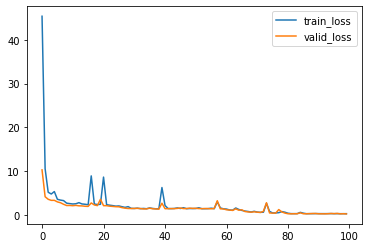

In [7]:
model = train(model,max_epochs=100)

In [8]:
wt_pred,op_pred = model(test[:,case_col_idx],test[:,feed_col_idx])

wt_pred = pd.DataFrame(wt_pred.detach().numpy(),columns=wt_col)
op_pred = pd.DataFrame(op_pred.detach().numpy(),columns=op_col)

wt_real = pd.DataFrame(test[:,wt_col_idx].detach().numpy(),columns=wt_col)
op_real = pd.DataFrame(test[:,op_col_idx].detach().numpy(),columns=op_col)

In [9]:
from sklearn.metrics import r2_score,mean_squared_error
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

def mape(y_true, y_pred, e = 2e-2):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  mask = y_true > e
  y_true, y_pred = y_true[mask], y_pred[mask]
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def show_metrics(y_real,y_pred,e=2e-2):
  res = pd.DataFrame(index=y_pred.columns,columns=['R2','MSE','MAPE'])
  for i in y_pred.columns:
      res.loc[i,'R2'] = np.clip(r2_score(y_real[i],y_pred[i]),0,1)
      res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
      res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i],e)
  res.loc['AVG'] = res.mean(axis=0)
  return res

In [10]:
show_metrics(op_real,op_pred)

,R2,MSE,MAPE
Density_Feed Properties,0,0.0106022,11.916
Density_Vent Gas Production Rate and Composition,0,0.0256082,35.463
Density_Distillate Production Rate and Composition,0,0.000298127,1.8845
Density_Sidedraw Production Rate and Composition,0,0.029467,19.446
Density_Bottoms Production Rate and Composition,0,0.0244642,17.8871
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,0.997008,0.39294,0.445468
Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.996239,0.00446902,0.43735
Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.966689,0.0549913,1.55491
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0.979599,0.0267248,0.0800285
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,0.928068,0.056983,0.118985


In [11]:
show_metrics(wt_real,wt_pred)

,R2,MSE,MAPE
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,1,0,NaN
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0.5087,0.00691486,2.61403
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0.827263,0.598607,1.27953
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0.105113,0.294415,1.26664
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0.66462,0.386227,4.19156
...,...,...,...
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,0,0.0132479,19.2595
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,0,0.00290613,19.9513
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1,0,NaN
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1,0,NaN


In [12]:
case = pd.DataFrame(test[:,case_col_idx].detach().numpy(),columns=case_col)
case.iloc[:,[2]]

,Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%
0,79.999992
1,70.000023
2,79.999992
3,90.000015
4,70.000008
...,...
1551,80.000015
1552,69.999992
1553,70.000008
1554,79.999992


In [13]:
wt_pred.iloc[:,[89]]

,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%
0,79.984703
1,69.993378
2,80.059685
3,89.947784
4,69.997917
...,...
1551,80.045837
1552,70.078987
1553,70.139374
1554,80.044846


In [14]:
wt_real.head()

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Com

In [15]:
wt_pred.head()

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Com

In [16]:
op_real.head()

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
0,0.862201,0.444712,0.796984,0.880099,0.871892,114.368935,11.975643,13.670486,176.726410,193.843842
1,0.862201,0.437196,0.810192,0.878842,0.871917,105.097725,11.598413,13.070837,177.635345,194.236511
2,0.864624,0.450002,0.783357,0.880260,0.872144,127.399017,12.864968,14.561686,177.027588,192.254578
3,0.864539,0.456023,0.798759,0.881600,0.872126,149.294113,15.159182,17.291943,175.597137,192.482269
4,0.862092,0.448472,0.788004,0.878749,0.871939,121.065727,12.355359,14.704842,177.941711,194.671448


In [17]:
op_pred.head()

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
0,0.962673,0.609526,0.792470,1.037208,0.729381,114.734192,12.019826,13.850540,176.809418,194.072968
1,0.964401,0.586937,0.781573,1.053056,0.737324,105.387207,11.637986,13.270376,177.766922,194.191727
2,0.972360,0.615780,0.771759,1.049871,0.727395,128.184799,12.918311,14.793971,177.118591,192.538666
3,0.975844,0.631254,0.792866,1.077317,0.706221,149.661606,15.167429,17.516125,175.748749,192.646729
4,0.959850,0.602441,0.772725,1.046122,0.716888,121.484894,12.377903,14.833161,178.119507,194.856339
